In [80]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow_datasets as tfds

## DATA
- Data is generated in Lorenz_data_creation.ipynb
- 4D Data (t,x,y,z)

In [81]:
mydf=np.genfromtxt('CSV\lorenz.csv',delimiter=',')
time=mydf[0, :]
mydf = mydf[1:, :]
print(mydf.shape,time.shape)


(3, 10000) (10000,)


In [82]:
def create_training_split(df, ratio=0.7):
    len_df = len(df)
    train = np.array(df[0:int(len_df*ratio)])
    valid = np.array(df[int(len_df*ratio):])
    return train, valid
def df_training_split(df, ratio=0.7):
    len_df_col = df.shape[1]
    train = np.array(df[:, 0:int(len_df_col*ratio)])
    valid = np.array(df[:, int(len_df_col*ratio):])
    return train, valid

In [83]:
df_train, df_valid = df_training_split(mydf)

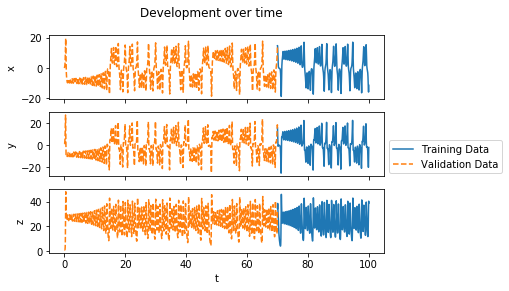

In [84]:
time_train, time_valid = create_training_split(time, ratio=0.7)
x_train, x_valid = create_training_split(mydf[0,:], ratio=0.7)
y_train, y_valid = create_training_split(mydf[1, :], ratio=0.7)
z_train, z_valid = create_training_split(mydf[2, :], ratio=0.7)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)  # , figsize=(15, 15))
fig.suptitle('Development over time')
ax1.plot(time_valid, x_valid, time_train, x_train, '--')
ax1.set_ylabel('x')
ax2.plot(time_valid, y_valid, time_train, y_train, '--')
ax2.set_ylabel('y')
ax3.plot(time_valid, z_valid,label='Training Data')
ax3.plot(time_train, z_train, '--', label='Validation Data')
ax3.set_ylabel('z')
ax3.set_xlabel('t')
ax3.legend(loc='center left', bbox_to_anchor=(1, 1.5))


### Windowing
- split the sequential data into windows to be fed into the network in batches

In [85]:
def windowing_1D(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)#creates a separate dataset for each window iteration
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) #this combines all windows into batches rather than individual datasets
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))#separates each window into features and label (next/last value)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

#create training and test sets
window_size=50
batch_size=32
shuffle_buffer_size = df_train.shape[1]
x_train_dataset = windowing_1D(
    x_train, window_size, batch_size, shuffle_buffer_size)
x_valid_dataset = windowing_1D(x_valid, window_size, batch_size, 1) #1 here avoids shuffling - it will make plotting of predictions easier


In [94]:
len(list(x_train_dataset))
x_train_np = np.array(list(x_train_dataset))

y_train_np = np.array(list(y_train_dataset))


C:\Users\elise\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
C:\Users\elise\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


In [104]:
x_train_np.shape

(218, 2)

In [171]:
x_y_train_data = np.vstack((x_train_np[:, 0], y_train_np[:, 0])).T
x_y_train_labels = np.vstack((x_train_np[:, 1], y_train_np[:, 1])).T
print('Shape of Training Data: ', x_y_train_data.shape, 'Shape of Training Labels: ', x_y_train_labels.shape)
#x_y_train = np.concatenate(x_y_train_data, x_y_train_labels)
print(type(x_y_train_data))
x_y_train = np.array([x_y_train_data, x_y_train_labels], dtype=np.ndarray)
#x_y_train = tf.convert_to_tensor(np.asarray(x_y_train).astype(np.ndarray)
type(x_train_np[:, 0])
tf.ragged.constant(x_y_train_data)


Shape of Training Data:  (218, 2) Shape of Training Labels:  (218, 2)
<class 'numpy.ndarray'>


ValueError: TypeError: Scalar tensor has no `len()`
Traceback (most recent call last):

  File "C:\Users\elise\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\ops.py", line 914, in __len__
    raise TypeError("Scalar tensor has no `len()`")

TypeError: Scalar tensor has no `len()`



In [69]:
y_train_dataset = windowing_1D(
    y_train, window_size, batch_size, shuffle_buffer_size)
y_valid_dataset = windowing_1D(y_valid, window_size, batch_size, 1)


In [66]:
series = df_train
for dimension in series:
    dimension = tf.data.Dataset.from_tensor_slices(series)
    # creates a separate dataset for each window iteration
    dimension = dimension.window(window_size + 1, shift=1, drop_remainder=True)
    # this combines all windows into batches rather than individual datasets
    dimension = dimension.flat_map(
        lambda window: window.batch(window_size + 1))
    # separates each window into features and label (next/last value)
    dimension = dimension.shuffle(shuffle_buffer_size).map(
        lambda window: (window[:-1], window[-1]))
    dimension = dataset.batch(batch_size).prefetch(1)
    print(list(dimension))



[<tf.Tensor: shape=(3, 7000), dtype=float64, numpy=
array([[ 0.        ,  0.09511585,  0.18268459, ..., 13.97978771,
        14.34487251, 14.61002868],
       [ 1.        ,  1.00303828,  1.03049742, ..., 18.03254301,
        17.48373282, 16.7031272 ],
       [ 1.05      ,  1.02284283,  0.99732053, ..., 29.73096468,
        31.4391503 , 33.05355927]])>]
[<tf.Tensor: shape=(3, 7000), dtype=float64, numpy=
array([[ 0.        ,  0.09511585,  0.18268459, ..., 13.97978771,
        14.34487251, 14.61002868],
       [ 1.        ,  1.00303828,  1.03049742, ..., 18.03254301,
        17.48373282, 16.7031272 ],
       [ 1.05      ,  1.02284283,  0.99732053, ..., 29.73096468,
        31.4391503 , 33.05355927]])>]
[<tf.Tensor: shape=(3, 7000), dtype=float64, numpy=
array([[ 0.        ,  0.09511585,  0.18268459, ..., 13.97978771,
        14.34487251, 14.61002868],
       [ 1.        ,  1.00303828,  1.03049742, ..., 18.03254301,
        17.48373282, 16.7031272 ],
       [ 1.05      ,  1.02284283,  0.9

In [53]:
print(df_train.shape)
train_dataset = windowing(df_train, window_size,
                          batch_size, shuffle_buffer_size)


(3, 7000)


In [ ]:
time_train_dataset=windowing(time_train, window_size, batch_size, shuffle_buffer_size)
time_valid_dataset=windowing(time_valid, window_size, batch_size, 1)

In [134]:
#preview the windowed dataset here
print(len(list(train_dataset)),  'batches of windows with ', window_size,' elements created from', len(x_train), ' datapoints')
for X, y in x_y_train:
    print("Features:", X, "Label:", y)


218 batches of windows with  50  elements created from 7000  datapoints


ValueError: too many values to unpack (expected 2)

## MODEL & TRAINING
Build a Recurrent Neural Network to predict the data at validation timesteps. We will be using the lambda layer twice: firstly to adjust the input layer as well as loss function - your data is now 1-D and the problem is no longer classification! The second lambda layer multiplies the hypothesis function by 100 to make the prediction on the same order of magnitude as the data (notice we are not using linear activation here).

#RNN

In [138]:
def build_model(lr):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(
            x, axis=-1), input_shape=[None]),
        tf.keras.layers.SimpleRNN(40, return_sequences=True),
        tf.keras.layers.SimpleRNN(40),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model


model = build_model(1e-5)
model.summary()
history = model.fit(x_y_train, epochs=2)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tensorflow.python.framework.ops.EagerTensor).

In [ ]:
#LSTM Model 

def build_model(lr):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(
        x, axis=-1), input_shape=[None]))
    # , input_shape=[None]))
    model.add(tf.keras.layers.LSTM(50, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    #model.compile(optimizer='adam', loss='mse')
    optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.Huber(), metrics=['mae'])
    return model


model = build_model(1e-5)
history = model.fit(train_dataset, epochs=2)
#model.summary()



## EVALUATE
Use your optimised model to predict and plot the validation data. 

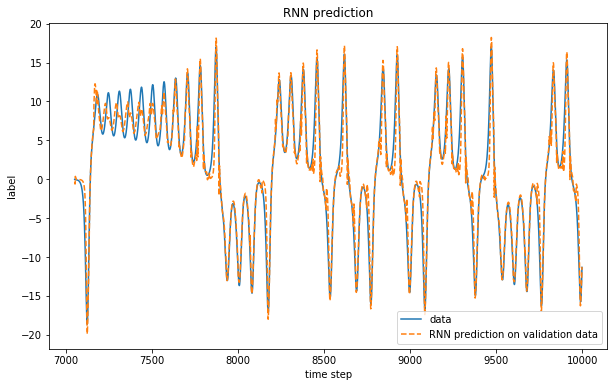

In [ ]:
forecast=model.predict(valid_dataset) #this has 50 fewer datapoints than the cell below
#plot your results alongside ground truth
plt.figure(figsize=(10, 6))
plt.plot(time_valid[50:],x_valid[50:], label='data')
plt.plot(time_valid[50:],forecast,'--', label='RNN prediction on validation data')
plt.xlabel('time step')
plt.ylabel('label')
plt.title('RNN prediction')
plt.legend()

No handles with labels found to put in legend.


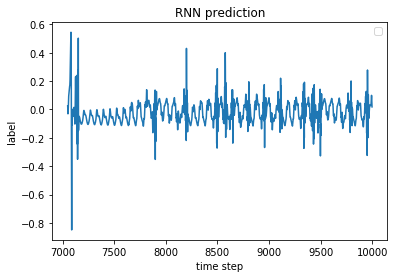

In [ ]:
pointwise_err = x_valid[50:].reshape(len(forecast),1)-forecast
plt.plot(time_valid[50:], pointwise_err)
plt.xlabel('time step')
plt.ylabel('label')
plt.title('RNN prediction')
plt.legend()


Alternatively, use <code>model.predict</code> window by window on the full dataset and only plot the validation part (after the split). It's important to remember to stop the loop before reaching the beginning of the last window, otherwise, the code will run out of data.

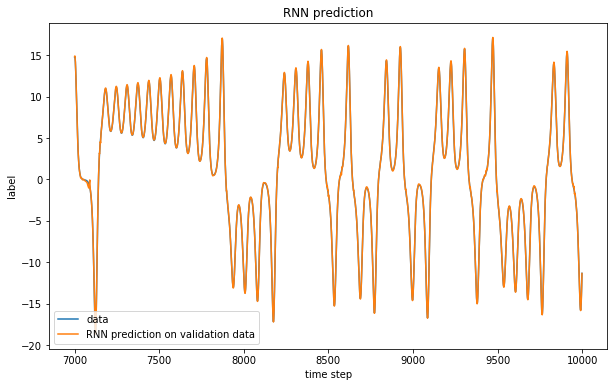

In [ ]:
prediction=[]
for time in range(len(mydf) - window_size):
    prediction.append(model.predict(mydf[time:time + window_size][np.newaxis]))

prediction = prediction[int(n*0.7)-window_size:]
results = np.array(prediction)[:, 0, 0]
#plot your results alongside ground truth
plt.figure(figsize=(10, 6))
plt.plot(time_valid,x_valid, label='data')
plt.plot(time_valid,results, label='RNN prediction on validation data')
plt.xlabel('time step')
plt.ylabel('label')
plt.title('RNN prediction')
plt.legend()